In [3]:
import time
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import DATASETS
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from tqdm import tqdm
import pickle
import random
import numpy as np
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
import gensim.downloader
from torch import FloatTensor as FT

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline

plt.style.use('ggplot')

In [4]:
# Where do I want to run my job. You can do "cuda" on linux machines.
DEVICE = "mps" if torch.backends.mps.is_available() else  "cpu"
# The batch size in Adam or SGD.
BATCH_SIZE = 512
# Number of epochs.
NUM_EPOCHS = 10
# Predict from 2 words the inner word for CBOW.
# I.e. I'll have a window like ["a", "b", "c"] of continuous text (each is a word).
# We'll predict each of wc = ["a", "c"] from "b" = wc for Skip-Gram.
# For CBOW, we'll use ["a", "c"] to predict "b" = wo.
WINDOW = 1

# Negative samples.
K = 4

In [5]:
f = open('text8', 'r')
text = f.read()
# One big string of size 100M.
print(len(text))

100000000


In [6]:
punc = '!"#$%&()*+,-./:;<=>?@[\\]^_\'{|}~\t\n'

# Can do regular expressions here too.
for c in punc:
    if c in text:
        text.replace(c, ' ')

In [7]:
# A very crude tokenizer you get for free: lower case and also split on spaces.
TOKENIZER = get_tokenizer("basic_english")

In [8]:
words = TOKENIZER(text)
f = Counter(words)

In [9]:
len(words)

17005207

In [10]:
# Do a very crude filter on the text which removes all very popular words.
text = [word for word in words if f[word] > 5]

In [11]:
text[0:5]

['anarchism', 'originated', 'as', 'a', 'term']

In [14]:
VOCAB = build_vocab_from_iterator([text])

In [16]:
# word -> int hash map.
stoi = VOCAB.get_stoi()
# int -> word hash map.
itos = VOCAB.get_itos() 

In [17]:
stoi['as']

11

In [19]:
# Total number of words.
len(stoi)

63641

In [20]:
f = Counter(text)
# This is the probability that we pick a word in the corpus.
z = {word: f[word] / len(text) for word in f}

In [21]:
threshold = 1e-5
# Probability that word is kept while subsampling.
# This is explained here and sightly differet from the paper: http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
p_keep = {word: (np.sqrt(z[word] / 0.001) + 1)*(0.0001 / z[word]) for word in f}


In [22]:
# This is in the integer space.
train_dataset = [word for word in text if random.random() < p_keep[word]]

# Rebuild the vocabulary.
VOCAB = build_vocab_from_iterator([train_dataset])

In [23]:
len(train_dataset)

7848699

In [24]:
# word -> int mapping.
stoi = VOCAB.get_stoi()
# int -> word mapping.
itos = VOCAB.get_itos() 

In [25]:
# The vocabulary size after we do all the filters.
len(VOCAB)

63641

In [27]:
# The probability we draw something for negative sampling.
f = Counter(train_dataset)
p = torch.zeros(len(VOCAB))

# Downsample frequent words and upsample less frequent.
s = sum([np.power(freq, 0.75) for word, freq in f.items()])        

for word in f:
    p[stoi[word]] = np.power(f[word], 0.75) / s

In [28]:
# Map everything to integers.
train_dataset = [stoi[word] for word in text]

In [41]:
# This just gets the (wc, wo) pairs that are positive - they are seen together!
def get_tokenized_dataset(dataset, verbose=False):
    x_list = []
        
    for i, token in enumerate(dataset):
        m = 1
        
        # Get the left and right tokens.
        start = i-m
        left_tokens = dataset[start:i]
        
        end = i+m
        right_tokens = dataset[i+1:end+1]
        
        # Check these are the same length, and if so use them to add a row of data. This should be a list like.
        # [a, c, b] where b is the center word.
        if len(left_tokens) == len(right_tokens):
            w_context = left_tokens + right_tokens
            
            wc = [token]
                        
            x_list.extend(
                [w_context + wc]
            )
            
    return x_list

In [42]:
train_x_list = get_tokenized_dataset(train_dataset, verbose=False)

In [44]:
pickle.dump(train_x_list, open('train_x_list.pkl', 'wb'))

In [45]:
train_x_list = pickle.load(open('train_x_list.pkl', 'rb'))

In [46]:
# These are (wc, wo) pairs. All are y = +1 by design.
train_x_list[:10]

[[5233, 11, 3083],
 [3083, 5, 11],
 [11, 193, 5],
 [5, 1, 193],
 [193, 3133, 1],
 [1, 43, 3133],
 [3133, 51, 43],
 [43, 152, 51],
 [51, 121, 152],
 [152, 740, 121]]

In [47]:
# The number of things of BATCH_SIZE = 512.
assert(len(train_x_list) // BATCH_SIZE == 32579)

### Set up the dataloader.

In [48]:
train_dl = DataLoader(
    TensorDataset(
        torch.tensor(train_x_list).to(DEVICE),
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [49]:
for xb in train_dl:
    assert(xb[0].shape == (BATCH_SIZE, 3))
    break

### Words we'll use to asses the quality of the model ...

In [54]:
valid_ids = torch.tensor([
    stoi['money'],
    stoi['lion'],
    stoi['africa'],
    stoi['musician'],
    stoi['dance'],
])

### Get the model.

In [94]:
class CBOWNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CBOWNegativeSampling, self).__init__()
        self.A = nn.Embedding(vocab_size, embed_dim) # Context vectors - center word.
        self.B = nn.Embedding(vocab_size, embed_dim) # Output vectors - words around the center word.
        self.init_weights()

    def init_weights(self):
        # Is this the best way? Not sure.
        initrange = 0.5
        self.A.weight.data.uniform_(-initrange, initrange)
        self.B.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        # N is the batch size.
        # x is (N, 3)
        
        # Context words are 2m things, m = 1 so w_context is (N, 2) while wc is (N, 1)
        w_context, wc = x[:, 0:2], x[:, 2]
                
        # Each of these is (N, 2, D) since each context has 2 word.
        # We want this to be (N, D) and this is what we get.
        
        # (N, 2, D)
        a = self.A(w_context)
        
        # (N, D)
        a_avg =  torch.mean(a, dim=1)
        
        # Each of these is (N, D) since each target has 1 word.
        b = self.B(wc)
                
        # The product between each context and target vector. Look at the Skip-Gram code.
        # The logits is now (N, 1) since we sum across the final dimension.
        logits = (a_avg * b).sum(axis=-1)
                
        return logits

In [95]:
@torch.no_grad()
def validate_embeddings(
    model,
    valid_ids,
    itos
):
    """ Validation logic """

    # We will use context embeddings to get the most similar words
    # Other strategies include: using target embeddings, mean embeddings after avaraging context/target
    embedding_weights = model.A.weight
        
    normalized_embeddings = embedding_weights.cpu() / np.sqrt(
        np.sum(embedding_weights.cpu().numpy()**2, axis=1, keepdims=True)
    )

    # Get the embeddings corresponding to valid_term_ids
    valid_embeddings = normalized_embeddings[valid_ids, :]

    # Compute the similarity between valid_term_ids (S) and all the embeddings (V).
    # We do S x d (d x V) => S x D and sort by negative similarity.
    top_k = 10 # Top k items will be displayed.
    similarity = np.dot(valid_embeddings.cpu().numpy(), normalized_embeddings.cpu().numpy().T)

    # Invert similarity matrix to negative
    # Ignore the first one because that would be the same word as the probe word
    similarity_top_k = np.argsort(-similarity, axis=1)[:, 1: top_k+1]

    # Print the output.
    for i, word_id in enumerate(valid_ids):
        # j >= 1 here since we don't want to include the word itself.
        similar_word_str = ', '.join([itos[j] for j in similarity_top_k[i, :] if j >= 1])
        print(f"{itos[word_id]}: {similar_word_str}")

    print('\n')

### Set up the model

In [96]:
LR = 10.0
NUM_EPOCHS = 10
EMBED_DIM = 300

In [97]:
model = CBOWNegativeSampling(len(VOCAB), EMBED_DIM).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# The learning rate is lowered every epoch by 1/10.
# Is this a good idea?
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1)

In [98]:
model

CBOWNegativeSampling(
  (A): Embedding(63641, 300)
  (B): Embedding(63641, 300)
)

In [99]:
validate_embeddings(model, valid_ids, itos)

money: boasting, rhee, dab, collectivists, accentuated, junk, universelle, nicolay, disparaged, isn
lion: baking, equilibrium, dalnet, reason, rosemont, framework, trapezohedron, overs, leyla, catal
africa: equalizer, distorts, peripheries, superseding, johnstown, asymmetrical, leathers, townhouse, acm, quicksilver
musician: phenomenally, mammalian, expiration, flowed, competent, fia, manitou, ananda, flourishing, alligator
dance: scandalous, trost, magnolia, doria, struct, iwo, connemara, mineralogy, bussy, hurdle




### Train the model

In [112]:
ratios = []

def train(dataloader, model, optimizer, epoch):
    model.train()
    total_acc, total_count, total_loss, total_batches = 0, 0, 0.0, 0.0
    log_interval = 500
    
    for idx, x_batch in tqdm(enumerate(dataloader)):
        
        x_batch = x_batch[0]
                
        batch_size = x_batch.shape[0]
        
        # Zero the gradient so they don't accumulate.
        optimizer.zero_grad()
        
        logits = model(x_batch)
                        
        # Get the positive samples loss. Notice we use weights here.
        positive_loss = torch.nn.BCEWithLogitsLoss()(input=logits, target=torch.ones(batch_size).to(DEVICE).float())
        
        # For each batch, get some negative samples.
        # We need a total of len(y_batch) * 2* WINDOW * K samples across a batch.
        # We then reshape this batch.
        # These are effectively the output words.
        negative_samples = torch.multinomial(p, batch_size * K, replacement=True)
        
        # Context words are 2m things, m = 1 so w_context is (N, 2) while wc is (N, 1)
        w_context, wc = x_batch[:, 0:2], negative_samples
        
        """
        if w_context looks like below (batch_size = 3)
        [
        (a, b),
        (c, d),
        (e, f)
        ] and K = 2 we'd like to get:
        
        [
        (a, b),
        (a, b),
        (c, d), 
        (c, d),
        (e, f),
        (e, f)
        ]
        
        This will be batch_size * K rows.
        """
        
        # This should be (N * K, 2)
        w_context = torch.concat([
            w.repeat(K, 1) for w in torch.tensor(w_context).split(1)
        ]).to(DEVICE)
        
        # Remove the last dimension 1.
        wc = wc.unsqueeze(1).to(DEVICE)
        
        # Get the negative samples. This should be (N * K, 3).
        # Concatenate the w_context and wc along the column. Make sure everything is on CUDA / MPS or CPU.
        x_batch_negative = torch.cat((w_context, wc), dim=1).to(DEVICE)
                
        """
        Note the way we formulated the targets: they are all 0 since these are negative samples.
        We do the BCEWithLogitsLoss by hand basically here.
        Notice we sum across the negative samples, per positive word.
        
        This is literally the equation in the lecture notes.
        """
        
        # (N, K, D) -> (N, D) -> (N)
        # Look at the Skip-Gram notebook.
        negative_loss = model(x_batch_negative).neg().sigmoid().log().reshape(
            batch_size, K
        ).sum(1).mean().neg().to(DEVICE)
        
        loss = (positive_loss + negative_loss).mean()
                
        # Get the gradients via back propagation. 
        loss.backward()
                        
        # Clip the gradients? Generally a good idea.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        # Used for optimization. This should be roughly 0.001, on average.
        # You can use this to see if your learning rate is right - you can also plot the loss performance.
        with torch.no_grad():
            r = [
                (LR * p.grad.std() / p.data.std()).log10().item() for _, p in model.named_parameters()
            ]
            ratios.append(r)  
        
        # Do an optimization step. Update the parameters A and B.
        optimizer.step()
        # Get the new loss.
        total_loss += loss.item()
        # Update the batch count.
        total_batches += 1
                
        if idx % log_interval == 0:
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| loss {:8.3f} ".format(
                    epoch,
                    idx,
                    len(dataloader),
                    total_loss / total_batches
                )
            )
            validate_embeddings(model, valid_ids, itos)
            total_loss, total_batches = 0.0, 0.0

### Some results from the run look like below:

Somewhere inside of 2 iterations you should get sensible associattions.
Paste here a screenshot of the closest vectors.

In [ ]:
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()
    
    train(train_dl, model, optimizer, epoch)
    # We have a learning rate scheduler here.
    # Basically, given the state of the optimizer, this lowers the learning rate in a smart way.
    scheduler.step()

0it [00:00, ?it/s]/var/folders/j4/q83784sx3x7cs3wwszb8whpr0000gn/T/ipykernel_64947/3823495315.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w.repeat(K, 1) for w in torch.tensor(w_context).split(1)
1it [00:02,  2.96s/it]

| epoch   1 |     0/32580 batches | loss    4.054 
money: boasting, rhee, dab, collectivists, accentuated, junk, universelle, nicolay, disparaged, isn
lion: baking, equilibrium, dalnet, reason, rosemont, framework, trapezohedron, overs, leyla, catal
africa: equalizer, distorts, peripheries, superseding, johnstown, asymmetrical, leathers, quicksilver, townhouse, acm
musician: phenomenally, mammalian, expiration, flowed, competent, fia, manitou, ananda, flourishing, alligator
dance: scandalous, trost, magnolia, doria, struct, iwo, connemara, mineralogy, bussy, hurdle




501it [02:07,  3.52it/s]

| epoch   1 |   500/32580 batches | loss    3.715 
money: boasting, rhee, collectivists, dab, accentuated, universelle, junk, nicolay, isn, disparaged
lion: baking, equilibrium, dalnet, rosemont, framework, reason, trapezohedron, overs, leyla, catal
africa: equalizer, peripheries, superseding, distorts, johnstown, asymmetrical, acm, bodies, synthesiser, townhouse
musician: phenomenally, mammalian, expiration, flowed, competent, manitou, fia, alligator, spurs, ananda
dance: scandalous, trost, doria, magnolia, struct, iwo, connemara, hurdle, mineralogy, bussy




1000it [04:10,  4.22it/s]

| epoch   1 |  1000/32580 batches | loss    3.366 


1001it [04:11,  2.68it/s]

money: boasting, rhee, dab, accentuated, collectivists, isn, universelle, junk, disparaged, nicolay
lion: baking, equilibrium, dalnet, rosemont, trapezohedron, reason, framework, overs, leyla, catal
africa: equalizer, peripheries, superseding, distorts, asymmetrical, johnstown, bodies, synthesiser, acm, bader
musician: phenomenally, mammalian, expiration, flowed, competent, fia, manitou, ananda, alligator, spurs
dance: scandalous, trost, magnolia, doria, struct, philosophies, iwo, hurdle, connemara, mineralogy




1501it [06:12,  3.29it/s]

| epoch   1 |  1500/32580 batches | loss    3.031 
money: boasting, rhee, accentuated, dab, collectivists, isn, universelle, disparaged, oros, nicolay
lion: equilibrium, baking, dalnet, trapezohedron, rosemont, framework, reason, overs, leyla, catal
africa: equalizer, peripheries, superseding, johnstown, distorts, asymmetrical, extipa, divisible, pvt, bader
musician: phenomenally, mammalian, flowed, expiration, competent, fia, manitou, ananda, alligator, spurs
dance: scandalous, magnolia, trost, struct, doria, philosophies, precondition, hurdle, iwo, connemara




2000it [1:34:13,  4.20it/s] 

| epoch   1 |  2000/32580 batches | loss    2.792 


2001it [1:36:45, 45.79s/it]

money: boasting, rhee, accentuated, dab, collectivists, isn, universelle, oros, disparaged, jobs
lion: equilibrium, baking, dalnet, rosemont, trapezohedron, framework, overs, reason, leyla, catal
africa: equalizer, peripheries, superseding, johnstown, divisible, horse, extipa, acm, bader, pvt
musician: phenomenally, mammalian, expiration, flowed, competent, fia, manitou, ananda, alligator, spurs
dance: scandalous, magnolia, doria, struct, philosophies, trost, p, hurdle, precondition, connemara




2500it [2:06:46,  3.21it/s]

| epoch   1 |  2500/32580 batches | loss    2.615 


2501it [2:06:46,  2.83it/s]

money: boasting, rhee, accentuated, dab, collectivists, isn, universelle, oros, said, jobs
lion: equilibrium, baking, dalnet, rosemont, trapezohedron, framework, overs, reason, catal, leyla
africa: equalizer, peripheries, superseding, divisible, johnstown, pvt, extipa, acm, bader, government
musician: mammalian, phenomenally, expiration, flowed, competent, fia, manitou, ananda, alligator, spurs
dance: scandalous, magnolia, p, doria, philosophies, struct, trost, precondition, hurdle, while




3001it [2:47:30,  4.15s/it]

| epoch   1 |  3000/32580 batches | loss    2.485 
money: boasting, rhee, said, dab, accentuated, isn, collectivists, jobs, universelle, oros
lion: equilibrium, baking, dalnet, rosemont, trapezohedron, framework, overs, catal, reason, barsoomian
africa: equalizer, government, superseding, pvt, horse, divisible, johnstown, bader, peripheries, acm
musician: mammalian, competent, phenomenally, flowed, expiration, fia, manitou, ananda, alligator, spurs
dance: scandalous, magnolia, p, doria, there, philosophies, struct, trost, while, hurdle




3500it [3:28:20,  4.20it/s]

| epoch   1 |  3500/32580 batches | loss    2.373 


3501it [3:30:57, 47.12s/it]

money: said, boasting, rhee, dab, jobs, collectivists, accentuated, isn, universelle, english
lion: equilibrium, dalnet, baking, rosemont, trapezohedron, overs, framework, catal, wlad, barsoomian
africa: equalizer, government, population, horse, superseding, pvt, bader, mahilyow, emphases, bodies
musician: competent, flowed, phenomenally, expiration, mammalian, fia, ananda, manitou, alligator, miskolc
dance: p, there, scandalous, magnolia, while, doria, philosophies, all, struct, hurdle




4000it [4:14:27, 16.39s/it]

| epoch   1 |  4000/32580 batches | loss    2.294 


4001it [4:14:27, 11.62s/it]

money: said, boasting, rhee, jobs, main, dab, english, creation, service, accentuated
lion: equilibrium, dalnet, baking, rosemont, trapezohedron, framework, overs, wlad, catal, barsoomian
africa: government, equalizer, population, horse, known, emphases, bodies, divisible, pvt, superseding
musician: competent, flowed, mammalian, expiration, phenomenally, fia, ananda, manitou, alligator, miskolc
dance: p, there, all, scandalous, while, magnolia, philosophies, doria, struct, precondition




4501it [4:47:20,  3.45it/s]

| epoch   1 |  4500/32580 batches | loss    2.218 
money: said, english, service, main, creation, rhee, order, information, jobs, music
lion: equilibrium, dalnet, baking, rosemont, trapezohedron, framework, overs, wlad, barsoomian, catal
africa: government, equalizer, population, known, may, world, germany, horse, most, an
musician: competent, flowed, mammalian, expiration, fia, american, phenomenally, ananda, manitou, miskolc
dance: there, p, while, all, scandalous, magnolia, external, philosophies, israel, struct




5001it [5:25:18,  3.27it/s]

| epoch   1 |  5000/32580 batches | loss    2.158 
money: said, english, order, music, information, main, service, game, creation, view
lion: equilibrium, dalnet, baking, trapezohedron, rosemont, framework, overs, wlad, barsoomian, reason
africa: government, population, known, equalizer, may, world, germany, over, example, under
musician: competent, flowed, american, expiration, fia, mammalian, ananda, economy, phenomenally, michigan
dance: p, there, all, while, external, scandalous, later, three, magnolia, d




5501it [6:08:50,  3.11it/s]

| epoch   1 |  5500/32580 batches | loss    2.103 
money: said, order, music, english, game, view, world, creation, information, main
lion: equilibrium, dalnet, baking, trapezohedron, rosemont, framework, overs, barsoomian, wlad, overstated
africa: government, population, known, world, may, germany, example, used, over, university
musician: competent, american, flowed, expiration, economy, michigan, com, fia, ananda, mammalian
dance: p, there, while, all, external, later, now, d, six, new




6001it [6:52:26,  3.56it/s]

| epoch   1 |  6000/32580 batches | loss    2.058 
money: said, order, form, game, music, view, creation, used, main, information
lion: equilibrium, dalnet, trapezohedron, baking, rosemont, framework, barsoomian, overs, wlad, reason
africa: government, known, population, world, example, used, may, germany, five, university
musician: competent, american, economy, com, empire, flowed, michigan, fia, expiration, equations
dance: p, while, all, there, external, later, d, now, new, six




6500it [7:33:28,  3.11it/s]

| epoch   1 |  6500/32580 batches | loss    2.025 


6501it [7:36:01, 46.01s/it]

money: said, order, form, game, used, main, view, music, work, received
lion: equilibrium, dalnet, trapezohedron, baking, rosemont, framework, barsoomian, wlad, overs, reason
africa: government, known, population, world, example, used, seven, germany, may, states
musician: american, economy, empire, com, competent, michigan, flowed, british, art, evidence
dance: p, while, all, there, six, external, name, now, five, new




7001it [8:17:03,  1.06it/s]

| epoch   1 |  7000/32580 batches | loss    1.975 
money: said, order, form, used, game, information, view, work, main, creation
lion: equilibrium, dalnet, trapezohedron, baking, rosemont, framework, reason, barsoomian, wlad, overs
africa: government, known, population, world, used, example, germany, seven, states, five
musician: american, economy, empire, com, british, competent, michigan, art, evidence, type
dance: p, all, there, while, name, six, external, them, five, three




7501it [8:59:26,  1.93it/s]

| epoch   1 |  7500/32580 batches | loss    1.942 
money: said, order, form, used, view, information, game, then, received, work
lion: equilibrium, dalnet, trapezohedron, baking, rosemont, framework, reason, barsoomian, wlad, overs
africa: government, known, population, world, used, germany, example, seven, five, west
musician: economy, empire, british, american, com, michigan, island, art, competent, french
dance: p, all, name, while, six, there, external, based, three, them




8001it [9:40:22, 47.38s/it]

| epoch   1 |  8000/32580 batches | loss    1.917 
money: said, order, form, used, view, information, game, work, received, then
lion: equilibrium, dalnet, trapezohedron, baking, rosemont, framework, reason, barsoomian, wlad, overstated
africa: government, known, germany, population, used, example, seven, world, west, nine
musician: empire, british, economy, american, com, island, french, art, michigan, government
dance: p, six, while, all, name, there, external, based, zero, best




8501it [10:24:07,  3.00s/it]

| epoch   1 |  8500/32580 batches | loss    1.890 
money: said, order, form, used, view, game, information, received, work, much
lion: equilibrium, dalnet, trapezohedron, reason, framework, baking, rosemont, barsoomian, thalberg, overs
africa: government, germany, known, population, seven, used, nine, example, west, world
musician: empire, economy, british, island, american, com, french, art, government, th
dance: p, six, all, while, name, external, three, people, best, zero




9000it [10:41:57,  3.51it/s]

| epoch   1 |  9000/32580 batches | loss    1.861 


9001it [10:41:59,  1.83it/s]

money: said, order, form, used, view, game, information, work, music, then
lion: equilibrium, dalnet, reason, trapezohedron, framework, baking, rosemont, barsoomian, duplicated, thalberg
africa: government, germany, known, population, used, nine, west, states, example, seven
musician: economy, empire, american, com, british, french, island, art, type, film
dance: p, six, name, while, all, people, external, best, based, zero




9500it [10:44:06,  4.22it/s]

| epoch   1 |  9500/32580 batches | loss    1.838 


9501it [10:44:07,  2.49it/s]

money: said, order, form, used, view, game, information, work, made, received
lion: equilibrium, dalnet, reason, trapezohedron, framework, baking, rosemont, barsoomian, duplicated, thalberg
africa: government, germany, known, nine, used, states, population, example, west, part
musician: empire, economy, com, french, american, island, british, art, type, film
dance: p, name, six, people, best, all, based, external, while, zero




10000it [10:46:14,  4.17it/s]

| epoch   1 | 10000/32580 batches | loss    1.816 


10001it [10:46:15,  2.59it/s]

money: said, order, form, used, view, game, made, information, received, work
lion: equilibrium, reason, dalnet, trapezohedron, framework, rosemont, baking, barsoomian, duplicated, thalberg
africa: government, germany, nine, states, known, used, population, example, part, west
musician: economy, empire, british, french, american, com, island, art, city, type
dance: p, name, best, zero, six, people, based, external, united, all




10501it [10:48:26,  3.41it/s]

| epoch   1 | 10500/32580 batches | loss    1.795 
money: said, order, form, used, view, game, made, received, work, part
lion: equilibrium, reason, dalnet, framework, trapezohedron, rosemont, baking, barsoomian, duplicated, thalberg
africa: government, germany, nine, population, known, example, used, states, part, west
musician: british, empire, economy, island, french, com, american, art, type, government
dance: name, p, best, six, people, zero, based, least, united, external




11001it [10:50:29,  3.42it/s]

| epoch   1 | 11000/32580 batches | loss    1.776 
money: said, order, form, used, view, game, made, received, work, part
lion: equilibrium, reason, framework, dalnet, trapezohedron, rosemont, baking, duplicated, research, barsoomian
africa: government, germany, nine, part, known, states, example, population, used, united
musician: british, empire, economy, french, island, american, com, type, art, film
dance: name, p, six, best, zero, people, based, least, four, united




11500it [11:12:42,  4.16it/s] 

| epoch   1 | 11500/32580 batches | loss    1.760 


11501it [11:12:43,  2.28it/s]

money: said, order, form, used, view, made, game, received, creation, part
lion: equilibrium, reason, framework, dalnet, trapezohedron, research, duplicated, baking, rosemont, barsoomian
africa: government, germany, example, nine, part, states, known, west, united, used
musician: british, empire, french, economy, island, com, american, art, type, thought
dance: name, p, six, best, least, music, zero, united, external, people




12001it [11:14:42,  3.38it/s]

| epoch   1 | 12000/32580 batches | loss    1.742 
money: said, order, form, used, view, made, received, part, creation, list
lion: equilibrium, reason, framework, dalnet, trapezohedron, course, duplicated, research, david, barsoomian
africa: government, germany, part, example, nine, west, states, known, population, america
musician: british, french, empire, island, economy, com, american, type, art, thought
dance: name, p, best, six, least, music, four, united, based, israel




12501it [11:16:53,  3.42it/s]

| epoch   1 | 12500/32580 batches | loss    1.729 
money: said, order, form, used, view, made, received, part, creation, time
lion: equilibrium, reason, framework, dalnet, trapezohedron, course, research, david, duplicated, barsoomian
africa: government, germany, part, west, example, nine, america, states, population, united
musician: british, french, empire, island, economy, com, art, american, type, thought
dance: name, p, best, six, least, eight, music, israel, external, united




13001it [11:18:52,  3.56it/s]

| epoch   1 | 13000/32580 batches | loss    1.720 
money: said, order, form, view, used, made, received, time, part, creation
lion: equilibrium, reason, framework, research, course, dalnet, david, trapezohedron, duplicated, space
africa: government, germany, nine, part, america, west, example, united, population, states
musician: british, empire, french, island, com, economy, american, type, india, art
dance: name, p, six, best, least, israel, four, external, eight, united




13500it [11:20:50,  4.22it/s]

| epoch   1 | 13500/32580 batches | loss    1.695 


13501it [11:20:51,  3.06it/s]

money: said, order, form, view, used, made, received, part, creation, referred
lion: equilibrium, reason, framework, course, research, david, dalnet, complete, space, trapezohedron
africa: government, germany, part, nine, america, west, example, united, population, europe
musician: british, island, empire, french, economy, com, government, type, india, american
dance: p, name, six, best, least, israel, type, eight, united, music




14001it [11:44:39,  3.25it/s] 

| epoch   1 | 14000/32580 batches | loss    1.678 
money: said, order, form, view, made, used, received, creation, time, game
lion: equilibrium, reason, framework, course, research, david, space, complete, medicine, dalnet
africa: government, germany, america, nine, part, united, west, europe, example, states
musician: island, empire, british, economy, french, india, type, government, actress, com
dance: p, six, name, best, music, israel, least, united, type, eight




14501it [11:46:41,  3.41it/s]

| epoch   1 | 14500/32580 batches | loss    1.670 
money: said, order, form, view, used, made, received, information, creation, change
lion: equilibrium, reason, course, framework, research, space, david, complete, medicine, duplicated
africa: government, germany, america, nine, part, europe, united, west, able, states
musician: island, british, empire, french, actress, economy, india, type, government, thought
dance: p, six, music, least, best, name, type, israel, eight, united




15001it [11:48:41,  3.65it/s]

| epoch   1 | 15000/32580 batches | loss    1.656 
money: said, order, form, view, received, used, made, able, creation, game
lion: equilibrium, reason, course, framework, research, david, space, complete, medicine, height
africa: government, germany, america, nine, part, europe, west, united, able, states
musician: island, empire, british, actress, french, type, india, author, economy, kingdom
dance: six, p, music, least, best, type, external, name, israel, united




15501it [11:50:42,  3.61it/s]

| epoch   1 | 15500/32580 batches | loss    1.646 
money: said, order, form, view, received, used, made, creation, able, information
lion: equilibrium, reason, course, research, framework, david, space, complete, medicine, height
africa: germany, government, nine, part, america, europe, west, able, united, india
musician: island, empire, actress, british, french, author, type, kingdom, india, economy
dance: p, least, external, six, best, music, name, israel, type, formed




16000it [11:52:53,  4.04it/s]

| epoch   1 | 16000/32580 batches | loss    1.634 


16001it [11:52:54,  2.57it/s]

money: said, order, form, view, received, used, made, creation, able, referred
lion: equilibrium, reason, course, framework, research, david, complete, space, medicine, height
africa: germany, government, europe, part, america, nine, west, able, india, united
musician: actress, british, island, empire, author, kingdom, french, type, government, india
dance: external, p, least, music, six, best, name, united, israel, eight




16500it [12:00:13,  3.46it/s]

| epoch   1 | 16500/32580 batches | loss    1.626 


16501it [12:00:14,  2.04it/s]

money: said, order, form, view, received, creation, made, used, able, example
lion: equilibrium, reason, course, research, framework, david, complete, space, medicine, height
africa: germany, europe, government, part, america, nine, india, able, west, united
musician: actress, empire, british, island, author, kingdom, french, thought, actor, india
dance: external, music, p, least, six, united, best, israel, name, seven




17000it [12:02:19,  4.21it/s]

| epoch   1 | 17000/32580 batches | loss    1.614 


17001it [12:02:19,  2.42it/s]

money: said, order, form, view, received, creation, used, able, made, referred
lion: equilibrium, reason, research, course, david, framework, space, complete, medicine, russia
africa: germany, europe, america, nine, part, government, india, able, west, united
musician: actress, author, empire, island, british, kingdom, actor, india, french, thought
dance: six, music, least, p, external, united, name, seven, best, israel




17500it [12:04:20,  4.24it/s]

| epoch   1 | 17500/32580 batches | loss    1.605 


17501it [12:04:21,  2.53it/s]

money: said, order, form, view, received, made, able, creation, used, referred
lion: equilibrium, reason, research, course, framework, complete, david, space, russia, medicine
africa: germany, europe, america, nine, part, india, able, government, west, united
musician: actress, author, empire, island, actor, british, kingdom, india, french, type
dance: music, six, external, least, p, united, name, zero, israel, seven




18001it [12:06:21,  3.41it/s]

| epoch   1 | 18000/32580 batches | loss    1.597 
money: said, order, form, made, received, view, able, creation, referred, used
lion: equilibrium, reason, research, course, framework, complete, david, space, height, medicine
africa: germany, europe, america, nine, part, india, able, government, end, united
musician: actress, author, island, actor, empire, kingdom, british, french, india, th
dance: music, six, external, least, p, name, formed, united, eight, island




18500it [12:08:21,  4.17it/s]

| epoch   1 | 18500/32580 batches | loss    1.585 


18501it [12:08:21,  3.31it/s]

money: said, order, form, view, made, able, received, creation, referred, change
lion: equilibrium, reason, research, course, framework, complete, david, space, carry, medicine
africa: germany, europe, america, india, nine, part, able, government, united, end
musician: actress, author, actor, island, kingdom, empire, india, french, th, british
dance: music, six, external, least, p, eight, name, united, israel, formed




19001it [12:10:22,  3.23it/s]

| epoch   1 | 19000/32580 batches | loss    1.579 
money: said, order, form, view, able, made, received, creation, referred, change
lion: reason, equilibrium, course, research, complete, framework, david, medicine, carry, space
africa: germany, europe, america, nine, part, india, able, end, united, kingdom
musician: actress, author, actor, island, kingdom, empire, french, india, british, daughter
dance: music, external, least, p, zero, united, six, island, israel, formed




19501it [12:12:22,  3.60it/s]

| epoch   1 | 19500/32580 batches | loss    1.569 
money: said, order, form, view, able, referred, received, creation, made, change
lion: reason, equilibrium, course, research, complete, framework, david, medicine, carry, space
africa: europe, germany, america, part, india, nine, able, end, kingdom, united
musician: actress, author, actor, island, kingdom, empire, french, india, daughter, british
dance: music, external, least, six, p, zero, eight, united, type, island




20001it [12:14:23,  3.39it/s]

| epoch   1 | 20000/32580 batches | loss    1.561 
money: said, order, form, view, able, creation, received, referred, made, change
lion: reason, equilibrium, course, research, complete, david, framework, medicine, carry, set
africa: europe, germany, america, india, part, kingdom, able, nine, end, united
musician: actress, author, actor, island, kingdom, empire, french, british, daughter, writer
dance: music, external, six, eight, type, united, least, best, p, battle




20500it [12:16:23,  4.15it/s]

| epoch   1 | 20500/32580 batches | loss    1.553 
money: said, order, form, view, able, creation, referred, received, seen, change
lion: reason, equilibrium, course, complete, research, david, framework, carry, medicine, height
africa: europe, germany, america, india, kingdom, nine, west, part, able, united
musician: actress, author, actor, kingdom, island, writer, empire, french, india, daughter
dance: music, external, eight, type, battle, united, six, least, new, zero




21001it [12:18:23,  3.33it/s]

| epoch   1 | 21000/32580 batches | loss    1.544 
money: said, order, form, view, able, creation, referred, received, change, seen
lion: reason, equilibrium, course, complete, research, david, framework, carry, medicine, set
africa: america, europe, germany, india, nine, kingdom, able, end, united, west
musician: actress, actor, author, kingdom, island, writer, empire, french, india, daughter
dance: music, external, eight, six, p, battle, united, type, least, zero




21500it [12:20:24,  4.17it/s]

| epoch   1 | 21500/32580 batches | loss    1.533 


21501it [12:20:24,  3.00it/s]

money: said, order, view, creation, form, able, referred, change, received, seen
lion: reason, course, equilibrium, complete, research, framework, david, carry, medicine, set
africa: america, europe, germany, india, nine, kingdom, end, able, west, united
musician: actress, actor, author, kingdom, writer, island, french, daughter, british, india
dance: music, external, six, battle, p, eight, united, seven, least, zero




22001it [12:22:24,  3.60it/s]

| epoch   1 | 22000/32580 batches | loss    1.536 
money: said, order, view, able, creation, form, referred, position, change, seen
lion: reason, equilibrium, course, complete, set, medicine, research, framework, david, carry
africa: america, germany, europe, india, nine, west, kingdom, able, united, china
musician: actress, actor, author, kingdom, writer, island, india, french, british, daughter
dance: music, external, six, battle, zero, p, least, united, seven, nine




22501it [12:24:24,  3.80it/s]

| epoch   1 | 22500/32580 batches | loss    1.522 
money: said, order, view, able, creation, referred, form, seen, made, support
lion: reason, equilibrium, course, complete, medicine, research, framework, carry, david, set
africa: america, germany, europe, india, nine, kingdom, west, north, united, end
musician: actress, actor, author, writer, kingdom, india, island, british, daughter, french
dance: music, external, battle, six, zero, least, p, united, seven, able




23000it [12:26:25,  4.04it/s]

| epoch   1 | 23000/32580 batches | loss    1.516 


23001it [12:26:25,  2.87it/s]

money: said, order, view, able, creation, made, referred, form, fact, change
lion: reason, equilibrium, course, complete, medicine, framework, david, carry, research, height
africa: germany, america, europe, india, nine, west, kingdom, able, north, united
musician: actress, actor, author, writer, kingdom, british, island, daughter, india, empire
dance: music, external, battle, seven, six, least, united, p, able, history




23500it [12:28:25,  4.21it/s]

| epoch   1 | 23500/32580 batches | loss    1.510 


23501it [12:28:26,  3.11it/s]

money: said, order, view, able, creation, made, fact, referred, seen, form
lion: reason, course, equilibrium, complete, medicine, david, framework, carry, height, set
africa: germany, america, india, europe, nine, kingdom, west, north, able, united
musician: actress, actor, author, writer, kingdom, daughter, india, poet, island, nine
dance: music, external, battle, least, united, seven, six, able, israel, p




24000it [12:30:27,  4.07it/s]

| epoch   1 | 24000/32580 batches | loss    1.506 


24001it [12:30:27,  2.99it/s]

money: order, said, able, view, creation, fact, referred, seen, made, position
lion: reason, course, equilibrium, complete, medicine, carry, framework, set, david, height
africa: germany, america, india, europe, nine, kingdom, west, able, north, united
musician: actress, actor, author, writer, kingdom, nine, india, daughter, poet, island
dance: music, external, battle, united, israel, seven, least, able, nine, history




24501it [12:32:28,  3.51it/s]

| epoch   1 | 24500/32580 batches | loss    1.501 
money: said, order, able, view, creation, fact, seen, referred, made, position
lion: reason, equilibrium, course, complete, carry, medicine, framework, david, height, set
africa: germany, america, europe, india, nine, kingdom, north, west, able, united
musician: actress, actor, author, writer, kingdom, nine, poet, india, daughter, composer
dance: music, external, battle, united, seven, israel, nine, least, standard, history




25000it [12:34:27,  4.23it/s]

| epoch   1 | 25000/32580 batches | loss    1.493 


25001it [12:34:27,  3.32it/s]

money: order, said, able, creation, view, fact, seen, referred, position, made
lion: reason, equilibrium, course, complete, medicine, carry, framework, height, david, spectrum
africa: germany, america, europe, india, nine, west, kingdom, north, able, united
musician: actress, actor, author, writer, kingdom, nine, poet, daughter, seven, composer
dance: music, external, battle, united, israel, history, least, traditional, standard, six




25501it [12:36:28,  3.60it/s]

| epoch   1 | 25500/32580 batches | loss    1.491 
money: said, order, able, creation, view, fact, seen, position, referred, made
lion: reason, equilibrium, course, complete, medicine, carry, framework, height, set, spectrum
africa: germany, america, europe, india, kingdom, west, north, nine, able, united
musician: actress, actor, author, writer, kingdom, poet, nine, daughter, composer, india
dance: music, external, battle, history, united, israel, traditional, six, nine, least




26000it [12:38:28,  4.19it/s]

| epoch   1 | 26000/32580 batches | loss    1.481 


26001it [12:38:28,  3.26it/s]

money: order, said, able, creation, view, fact, seen, position, referred, addition
lion: reason, equilibrium, course, complete, medicine, carry, set, height, framework, failure
africa: germany, america, europe, india, kingdom, west, north, nine, able, united
musician: actress, actor, author, writer, kingdom, poet, nine, composer, seven, daughter
dance: music, external, battle, traditional, israel, united, standard, history, nine, least




26500it [12:40:28,  4.21it/s]

| epoch   1 | 26500/32580 batches | loss    1.478 


26501it [12:40:29,  3.12it/s]

money: said, order, able, creation, view, seen, position, fact, referred, much
lion: reason, equilibrium, course, complete, medicine, carry, height, failure, framework, set
africa: america, germany, europe, india, kingdom, north, west, south, able, nine
musician: actress, actor, author, writer, kingdom, poet, composer, daughter, nine, th
dance: music, external, battle, traditional, israel, united, history, new, standard, least




27000it [12:42:29,  4.05it/s]

| epoch   1 | 27000/32580 batches | loss    1.469 


27001it [12:42:30,  3.27it/s]

money: said, able, order, creation, fact, seen, view, position, made, return
lion: reason, course, equilibrium, complete, medicine, carry, framework, height, spectrum, failure
africa: america, germany, europe, india, west, north, kingdom, nine, south, able
musician: actress, actor, author, writer, poet, kingdom, composer, nine, daughter, th
dance: music, external, battle, israel, united, traditional, standard, able, least, seven




27500it [14:36:19,  2.40s/it] 

| epoch   1 | 27500/32580 batches | loss    1.466 


27501it [14:36:19,  1.82s/it]

money: said, able, creation, order, seen, fact, view, made, position, return
lion: reason, course, equilibrium, complete, medicine, framework, height, failure, carry, spectrum
africa: germany, america, india, europe, north, west, kingdom, south, able, nine
musician: actress, actor, author, writer, poet, kingdom, composer, daughter, nine, th
dance: music, external, history, battle, united, traditional, israel, seven, standard, new




28000it [17:55:21, 293.46s/it]

| epoch   1 | 28000/32580 batches | loss    1.461 


28001it [17:55:23, 205.80s/it]

money: said, able, creation, order, seen, fact, return, view, position, made
lion: reason, course, equilibrium, complete, medicine, framework, return, carry, failure, height
africa: america, india, germany, europe, west, kingdom, north, nine, south, able
musician: actress, actor, author, writer, poet, kingdom, composer, singer, nine, daughter
dance: music, external, history, united, battle, six, israel, new, least, traditional




28500it [18:17:31,  3.39it/s] 

| epoch   1 | 28500/32580 batches | loss    1.457 


28501it [18:17:34,  1.01s/it]

money: able, said, creation, seen, order, fact, view, return, position, referred
lion: reason, course, equilibrium, complete, medicine, return, framework, failure, carry, height
africa: america, india, germany, europe, kingdom, north, west, nine, south, united
musician: actress, actor, author, writer, poet, kingdom, composer, singer, nine, seven
dance: music, external, history, six, battle, united, new, popular, israel, original




29000it [18:19:36,  4.26it/s]

| epoch   1 | 29000/32580 batches | loss    1.450 


29001it [18:19:36,  2.84it/s]

money: creation, able, seen, said, order, fact, much, return, view, made
lion: reason, course, equilibrium, complete, medicine, return, framework, failure, russia, height
africa: america, india, germany, europe, kingdom, nine, north, able, west, south
musician: actress, actor, author, writer, poet, kingdom, composer, singer, seven, nine
dance: music, external, history, six, battle, united, popular, able, traditional, new




29500it [18:21:36,  4.17it/s]

| epoch   1 | 29500/32580 batches | loss    1.445 


29501it [18:21:37,  3.00it/s]

money: creation, able, seen, order, fact, said, return, made, position, much
lion: reason, course, equilibrium, complete, medicine, russia, failure, return, framework, carry
africa: america, india, germany, europe, kingdom, nine, north, china, west, south
musician: actress, actor, author, writer, poet, composer, kingdom, singer, seven, nine
dance: music, external, history, battle, popular, traditional, united, able, original, israel




30000it [18:23:36,  4.20it/s]

| epoch   1 | 30000/32580 batches | loss    1.445 


30001it [18:23:37,  2.98it/s]

money: creation, able, seen, made, said, order, fact, return, view, position
lion: reason, course, complete, equilibrium, medicine, failure, return, framework, height, carry
africa: america, germany, india, europe, kingdom, north, nine, china, able, south
musician: actress, actor, author, writer, poet, composer, kingdom, singer, canadian, seven
dance: music, external, history, six, battle, united, able, traditional, original, popular




30501it [18:25:36,  3.45it/s]

| epoch   1 | 30500/32580 batches | loss    1.433 
money: creation, able, seen, said, made, fact, much, order, return, support
lion: reason, course, equilibrium, complete, medicine, failure, return, framework, russia, height
africa: america, germany, india, europe, kingdom, nine, north, china, able, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, history, united, battle, six, traditional, able, popular, original




31000it [18:27:35,  4.25it/s]

| epoch   1 | 31000/32580 batches | loss    1.433 


31001it [18:27:36,  2.26it/s]

money: seen, able, creation, fact, much, order, made, support, said, return
lion: reason, course, complete, equilibrium, medicine, failure, framework, return, height, carry
africa: america, germany, india, europe, nine, north, kingdom, south, china, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, history, united, traditional, battle, popular, original, able, six




31500it [18:29:50,  4.18it/s]

| epoch   1 | 31500/32580 batches | loss    1.430 


31501it [18:29:50,  3.12it/s]

money: able, creation, seen, made, much, said, fact, support, order, return
lion: reason, course, complete, equilibrium, medicine, failure, return, framework, carry, height
africa: germany, india, america, europe, north, kingdom, nine, south, china, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, history, traditional, early, united, original, battle, able, popular




32000it [18:31:50,  4.06it/s]

| epoch   1 | 32000/32580 batches | loss    1.424 


32001it [18:31:51,  2.28it/s]

money: creation, seen, able, made, support, return, much, fact, said, order
lion: reason, course, complete, medicine, equilibrium, failure, return, framework, carry, russia
africa: germany, india, europe, america, nine, kingdom, north, china, united, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, history, traditional, original, early, battle, united, able, popular




32501it [18:33:51,  3.50it/s]

| epoch   1 | 32500/32580 batches | loss    1.415 
money: seen, creation, able, made, much, support, return, fact, order, said
lion: reason, course, complete, failure, equilibrium, medicine, return, carry, framework, russia
africa: america, india, germany, europe, kingdom, nine, north, china, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, daughter
dance: music, external, history, traditional, original, early, united, battle, popular, able




32580it [18:34:17,  2.05s/it]
0it [00:00, ?it/s]

| epoch   2 |     0/32580 batches | loss    1.296 


1it [00:02,  2.37s/it]

money: seen, much, creation, able, made, support, return, fact, order, information
lion: reason, course, complete, equilibrium, failure, medicine, return, carry, framework, russia
africa: america, india, germany, europe, kingdom, nine, north, china, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, history, traditional, original, early, united, battle, popular, able




500it [02:03,  4.30it/s]

| epoch   2 |   500/32580 batches | loss    1.379 


501it [02:03,  3.20it/s]

money: seen, much, creation, able, made, support, return, fact, order, information
lion: reason, course, complete, equilibrium, failure, medicine, return, carry, framework, russia
africa: america, india, germany, europe, nine, kingdom, north, china, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, history, traditional, original, early, united, battle, popular, able




1000it [04:02,  4.26it/s]

| epoch   2 |  1000/32580 batches | loss    1.375 


1001it [04:03,  3.23it/s]

money: seen, much, creation, able, made, support, return, fact, order, information
lion: reason, course, complete, equilibrium, failure, medicine, return, carry, framework, russia
africa: america, india, germany, europe, kingdom, nine, north, china, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, history, traditional, original, early, united, battle, popular, able




1500it [06:06,  3.37it/s]

| epoch   2 |  1500/32580 batches | loss    1.370 


1501it [06:07,  2.20it/s]

money: seen, creation, much, able, made, return, support, fact, information, order
lion: reason, course, equilibrium, failure, complete, medicine, return, carry, framework, russia
africa: america, india, germany, europe, kingdom, nine, north, china, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, history, traditional, original, early, united, battle, popular, able




2000it [08:19,  3.77it/s]

| epoch   2 |  2000/32580 batches | loss    1.372 


2001it [08:19,  2.38it/s]

money: seen, creation, much, able, made, support, return, fact, information, order
lion: reason, course, equilibrium, failure, complete, medicine, return, carry, framework, russia
africa: america, india, germany, europe, kingdom, nine, north, china, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, history, traditional, original, early, united, battle, popular, able




2500it [10:28,  3.84it/s]

| epoch   2 |  2500/32580 batches | loss    1.369 


2501it [10:29,  2.33it/s]

money: creation, seen, much, able, made, return, support, fact, information, order
lion: reason, course, complete, failure, equilibrium, medicine, return, carry, framework, russia
africa: america, india, germany, europe, kingdom, nine, north, china, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, history, traditional, original, early, united, battle, popular, able




3000it [12:37,  3.92it/s]

| epoch   2 |  3000/32580 batches | loss    1.368 


3001it [12:38,  3.10it/s]

money: creation, seen, much, able, made, return, support, fact, information, order
lion: reason, course, failure, equilibrium, complete, medicine, return, carry, framework, russia
africa: america, india, germany, europe, kingdom, nine, north, china, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, history, traditional, original, early, united, battle, popular, able




3500it [14:49,  3.91it/s]

| epoch   2 |  3500/32580 batches | loss    1.363 


3501it [14:50,  2.10it/s]

money: seen, creation, much, able, made, return, support, fact, information, order
lion: reason, course, failure, equilibrium, complete, medicine, return, carry, framework, russia
africa: america, india, germany, europe, kingdom, nine, north, china, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, history, traditional, original, early, united, battle, popular, able




4000it [17:07,  3.48it/s]

| epoch   2 |  4000/32580 batches | loss    1.364 


4001it [17:08,  1.90it/s]

money: seen, creation, much, able, made, return, support, fact, information, order
lion: reason, course, failure, equilibrium, complete, medicine, return, carry, framework, russia
africa: america, india, germany, europe, kingdom, nine, north, china, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, history, traditional, original, early, united, battle, popular, able




4500it [19:18,  3.78it/s]

| epoch   2 |  4500/32580 batches | loss    1.364 


4501it [19:19,  2.47it/s]

money: seen, creation, much, able, made, return, support, fact, information, order
lion: reason, course, failure, complete, equilibrium, medicine, return, carry, framework, russia
africa: america, india, germany, europe, kingdom, nine, north, china, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, history, traditional, original, early, united, battle, popular, able




5000it [21:27,  3.86it/s]

| epoch   2 |  5000/32580 batches | loss    1.361 


5001it [21:28,  2.75it/s]

money: seen, creation, much, able, made, return, support, fact, information, order
lion: reason, course, failure, complete, equilibrium, medicine, return, framework, carry, russia
africa: india, america, germany, europe, kingdom, nine, north, china, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, history, traditional, original, early, united, battle, popular, able




5500it [23:36,  3.82it/s]

| epoch   2 |  5500/32580 batches | loss    1.369 


5501it [23:37,  2.65it/s]

money: creation, seen, much, able, made, return, support, fact, information, order
lion: reason, course, failure, complete, equilibrium, medicine, return, framework, carry, russia
africa: america, india, germany, europe, kingdom, nine, north, china, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, history, original, early, united, popular, battle, able




6001it [25:47,  3.31it/s]

| epoch   2 |  6000/32580 batches | loss    1.367 
money: creation, seen, much, able, made, return, support, fact, information, order
lion: reason, course, failure, complete, equilibrium, medicine, return, framework, carry, russia
africa: india, america, germany, europe, kingdom, nine, china, north, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, history, original, early, united, popular, battle, able




6500it [28:03,  3.61it/s]

| epoch   2 |  6500/32580 batches | loss    1.362 


6501it [28:04,  2.15it/s]

money: creation, seen, much, able, made, return, support, fact, information, order
lion: reason, course, failure, complete, equilibrium, medicine, return, framework, carry, russia
africa: america, india, germany, europe, kingdom, nine, china, north, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, history, original, early, united, popular, battle, able




7000it [30:16,  3.87it/s]

| epoch   2 |  7000/32580 batches | loss    1.358 


7001it [30:17,  1.87it/s]

money: creation, seen, much, able, made, return, support, fact, information, order
lion: reason, course, failure, complete, equilibrium, medicine, return, framework, carry, russia
africa: america, india, germany, europe, kingdom, nine, china, north, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, history, original, early, united, popular, battle, classical




7500it [33:36,  3.86it/s]

| epoch   2 |  7500/32580 batches | loss    1.357 


7501it [33:36,  2.98it/s]

money: creation, much, seen, able, made, return, support, fact, order, information
lion: reason, course, failure, medicine, complete, equilibrium, return, framework, carry, russia
africa: america, india, germany, europe, kingdom, nine, china, north, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, history, original, early, united, popular, battle, classical




8000it [36:00,  3.73it/s]

| epoch   2 |  8000/32580 batches | loss    1.361 


8001it [36:00,  3.00it/s]

money: creation, much, seen, able, made, return, support, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, framework, carry, russia
africa: america, india, germany, europe, kingdom, nine, china, north, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, history, early, united, popular, battle, classical




8500it [38:18,  3.71it/s]

| epoch   2 |  8500/32580 batches | loss    1.362 


8501it [38:19,  2.39it/s]

money: creation, much, seen, able, made, return, support, fact, order, information
lion: reason, course, failure, medicine, equilibrium, complete, return, framework, carry, russia
africa: america, india, germany, europe, kingdom, nine, china, north, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, history, original, early, popular, united, battle, classical




9000it [40:32,  3.43it/s]

| epoch   2 |  9000/32580 batches | loss    1.362 


9001it [40:33,  2.24it/s]

money: creation, much, seen, able, made, return, support, fact, order, information
lion: reason, course, failure, medicine, equilibrium, complete, return, framework, carry, russia
africa: america, india, germany, europe, kingdom, nine, china, north, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, early, popular, united, battle, classical




9500it [42:50,  3.22it/s]

| epoch   2 |  9500/32580 batches | loss    1.358 


9501it [42:52,  1.77it/s]

money: creation, much, seen, able, made, return, support, fact, order, information
lion: reason, course, failure, equilibrium, medicine, complete, return, framework, carry, russia
africa: india, america, germany, europe, kingdom, china, north, nine, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, early, popular, united, battle, classical




10000it [45:10,  3.77it/s]

| epoch   2 | 10000/32580 batches | loss    1.360 


10001it [45:11,  2.60it/s]

money: creation, much, seen, able, made, return, support, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, framework, carry, russia
africa: india, america, germany, europe, kingdom, china, nine, north, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, early, popular, united, battle, classical




10500it [47:28,  3.68it/s]

| epoch   2 | 10500/32580 batches | loss    1.359 


10501it [47:28,  2.25it/s]

money: much, creation, seen, able, made, return, support, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, framework, carry, height
africa: india, america, germany, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, history, early, popular, united, battle, classical




11000it [49:38,  3.82it/s]

| epoch   2 | 11000/32580 batches | loss    1.362 


11001it [49:39,  2.73it/s]

money: much, creation, seen, able, made, return, support, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, carry, framework, height
africa: india, america, germany, europe, kingdom, north, china, nine, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, history, early, popular, united, battle, classical




11500it [51:53,  3.93it/s]

| epoch   2 | 11500/32580 batches | loss    1.356 


11501it [51:54,  2.09it/s]

money: much, creation, seen, able, made, return, support, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, carry, framework, height
africa: india, america, germany, europe, kingdom, north, china, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, history, early, popular, united, battle, classical




12000it [54:04,  3.91it/s]

| epoch   2 | 12000/32580 batches | loss    1.358 


12001it [54:05,  2.90it/s]

money: much, creation, seen, able, made, return, support, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, carry, framework, height
africa: india, germany, america, europe, kingdom, china, north, nine, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, history, early, popular, united, battle, classical




12500it [56:15,  3.85it/s]

| epoch   2 | 12500/32580 batches | loss    1.354 


12501it [56:16,  2.69it/s]

money: much, creation, seen, able, made, return, support, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, carry, framework, height
africa: india, germany, america, europe, kingdom, china, north, nine, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, history, early, popular, united, battle, classical




13000it [58:26,  3.86it/s]

| epoch   2 | 13000/32580 batches | loss    1.351 


13001it [58:27,  2.93it/s]

money: much, creation, seen, able, made, return, support, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, carry, framework, height
africa: india, america, germany, europe, kingdom, china, north, nine, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, history, popular, early, united, battle, classical




13500it [1:00:36,  3.84it/s]

| epoch   2 | 13500/32580 batches | loss    1.356 


13501it [1:00:37,  2.93it/s]

money: much, creation, seen, able, made, return, support, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, carry, framework, height
africa: india, america, germany, europe, kingdom, north, china, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, history, popular, early, united, battle, classical




14000it [1:02:49,  3.92it/s]

| epoch   2 | 14000/32580 batches | loss    1.354 


14001it [1:02:49,  2.70it/s]

money: much, creation, seen, able, made, return, support, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, carry, framework, height
africa: india, germany, america, europe, kingdom, north, china, nine, united, france
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, united, battle, classical




14500it [1:05:00,  3.66it/s]

| epoch   2 | 14500/32580 batches | loss    1.355 


14501it [1:05:01,  2.19it/s]

money: much, creation, seen, able, made, return, support, fact, information, order
lion: reason, course, failure, medicine, equilibrium, complete, return, carry, height, framework
africa: india, germany, america, europe, kingdom, north, china, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, history, popular, early, united, classical, battle




15000it [1:07:11,  3.90it/s]

| epoch   2 | 15000/32580 batches | loss    1.354 


15001it [1:07:12,  3.00it/s]

money: much, creation, seen, able, made, return, support, fact, information, order
lion: reason, course, failure, medicine, equilibrium, complete, return, carry, height, framework
africa: india, america, germany, europe, kingdom, north, china, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, united, battle, classical




15500it [1:09:21,  3.29it/s]

| epoch   2 | 15500/32580 batches | loss    1.355 


15501it [1:09:22,  2.41it/s]

money: much, creation, seen, able, made, return, support, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, carry, height, framework
africa: india, america, germany, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, united, battle, classical




16000it [1:11:32,  3.31it/s]

| epoch   2 | 16000/32580 batches | loss    1.356 


16001it [1:11:33,  2.22it/s]

money: much, creation, seen, able, made, support, return, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, carry, height, framework
africa: india, america, germany, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, united, battle, able




16500it [1:13:36,  3.67it/s]

| epoch   2 | 16500/32580 batches | loss    1.357 


16501it [1:13:37,  2.20it/s]

money: much, creation, seen, able, made, support, return, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, height, carry, framework
africa: india, germany, america, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, united, battle, able




17000it [2:43:58,  4.21it/s] 

| epoch   2 | 17000/32580 batches | loss    1.353 


17001it [2:43:59,  2.18it/s]

money: much, creation, seen, able, made, support, return, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, carry, height, framework
africa: india, germany, america, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, united, able, battle




17500it [4:29:36,  4.08it/s] 

| epoch   2 | 17500/32580 batches | loss    1.354 


17501it [4:29:36,  3.25it/s]

money: much, creation, seen, able, made, support, return, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, height, carry, framework
africa: india, germany, america, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, united, able, battle




18000it [4:31:42,  3.96it/s]

| epoch   2 | 18000/32580 batches | loss    1.354 


18001it [4:31:43,  2.71it/s]

money: creation, much, seen, able, made, support, return, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, height, carry, framework
africa: india, germany, america, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, united, able, classical




18501it [4:33:46,  3.14it/s]

| epoch   2 | 18500/32580 batches | loss    1.352 
money: creation, much, seen, able, made, support, return, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, height, carry, framework
africa: india, germany, america, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, united, able, classical




19000it [4:35:49,  4.06it/s]

| epoch   2 | 19000/32580 batches | loss    1.348 


19001it [4:35:50,  3.10it/s]

money: much, creation, seen, able, made, support, return, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, height, carry, framework
africa: india, america, germany, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, united, classical, able




19501it [4:37:53,  3.27it/s]

| epoch   2 | 19500/32580 batches | loss    1.354 
money: much, creation, seen, able, made, support, return, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, height, carry, framework
africa: india, germany, america, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, united, classical, able




20001it [4:39:57,  3.48it/s]

| epoch   2 | 20000/32580 batches | loss    1.347 
money: much, creation, seen, able, made, support, return, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, carry, height, framework
africa: india, germany, america, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, united, classical, able




20501it [4:41:59,  3.21it/s]

| epoch   2 | 20500/32580 batches | loss    1.354 
money: much, creation, seen, able, made, support, return, fact, information, order
lion: reason, course, failure, equilibrium, medicine, return, complete, carry, height, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, united, classical, able




21000it [4:44:03,  3.96it/s]

| epoch   2 | 21000/32580 batches | loss    1.353 


21001it [4:44:04,  2.55it/s]

money: much, creation, seen, able, made, support, return, fact, information, order
lion: reason, course, failure, equilibrium, medicine, return, complete, carry, height, framework
africa: india, germany, america, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, united, classical, able




21501it [4:46:07,  3.40it/s]

| epoch   2 | 21500/32580 batches | loss    1.350 
money: much, creation, seen, able, made, support, return, fact, information, order
lion: reason, course, failure, equilibrium, medicine, return, complete, carry, height, framework
africa: india, germany, america, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, united, classical, able




22001it [4:48:10,  3.37it/s]

| epoch   2 | 22000/32580 batches | loss    1.351 
money: much, creation, seen, able, made, support, return, fact, information, order
lion: reason, course, failure, equilibrium, medicine, complete, return, carry, height, framework
africa: india, germany, america, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, classical, united, able




22500it [4:50:14,  4.00it/s]

| epoch   2 | 22500/32580 batches | loss    1.348 


22501it [4:50:15,  3.12it/s]

money: much, creation, seen, able, made, support, return, fact, information, order
lion: reason, course, failure, equilibrium, medicine, return, complete, height, carry, framework
africa: india, germany, america, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, classical, united, able




23000it [4:52:20,  3.96it/s]

| epoch   2 | 23000/32580 batches | loss    1.351 


23001it [4:52:20,  2.91it/s]

money: much, creation, seen, able, made, support, return, fact, information, order
lion: reason, course, failure, equilibrium, medicine, return, complete, height, carry, framework
africa: india, germany, america, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, classical, united, able




23501it [4:54:24,  3.52it/s]

| epoch   2 | 23500/32580 batches | loss    1.349 
money: much, creation, seen, able, made, support, return, fact, information, order
lion: reason, course, failure, medicine, equilibrium, return, complete, carry, height, framework
africa: india, germany, america, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, classical, united, able




24001it [4:56:28,  3.18it/s]

| epoch   2 | 24000/32580 batches | loss    1.347 
money: much, creation, seen, able, made, support, return, fact, information, position
lion: reason, course, failure, medicine, equilibrium, return, complete, carry, height, framework
africa: india, germany, america, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, classical, united, able




24501it [4:58:31,  3.57it/s]

| epoch   2 | 24500/32580 batches | loss    1.348 
money: much, creation, seen, able, made, support, return, fact, information, position
lion: reason, course, failure, medicine, equilibrium, return, complete, carry, height, framework
africa: india, germany, america, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, classical, united, able




25000it [5:00:36,  3.99it/s]

| epoch   2 | 25000/32580 batches | loss    1.352 


25001it [5:00:37,  3.19it/s]

money: much, creation, seen, able, made, support, return, fact, information, position
lion: reason, course, failure, medicine, equilibrium, return, complete, carry, height, framework
africa: india, germany, america, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, classical, united, able




25500it [5:02:41,  3.72it/s]

| epoch   2 | 25500/32580 batches | loss    1.344 


25501it [5:02:42,  2.67it/s]

money: much, creation, seen, able, made, support, return, fact, information, position
lion: reason, course, failure, medicine, equilibrium, return, complete, carry, height, framework
africa: india, germany, america, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, classical, united, able




26000it [5:04:45,  4.15it/s]

| epoch   2 | 26000/32580 batches | loss    1.345 


26001it [5:04:46,  3.14it/s]

money: much, creation, seen, able, made, support, return, fact, information, position
lion: reason, course, failure, medicine, equilibrium, return, complete, carry, height, framework
africa: india, germany, america, europe, kingdom, china, north, nine, france, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, classical, united, able




26501it [5:06:49,  3.28it/s]

| epoch   2 | 26500/32580 batches | loss    1.348 
money: much, creation, seen, able, support, made, return, fact, information, position
lion: reason, course, failure, medicine, equilibrium, return, complete, height, carry, framework
africa: india, germany, america, europe, kingdom, china, north, nine, france, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, classical, united, able




27000it [5:08:51,  4.09it/s]

| epoch   2 | 27000/32580 batches | loss    1.344 


27001it [5:08:51,  2.87it/s]

money: much, creation, seen, able, made, support, return, fact, information, position
lion: reason, course, failure, medicine, equilibrium, return, complete, carry, height, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, classical, united, able




27500it [5:10:53,  3.91it/s]

| epoch   2 | 27500/32580 batches | loss    1.344 


27501it [5:10:54,  3.18it/s]

money: much, creation, seen, able, support, made, return, fact, information, position
lion: reason, course, failure, medicine, equilibrium, return, complete, height, carry, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, classical, united, able




28001it [5:12:56,  3.51it/s]

| epoch   2 | 28000/32580 batches | loss    1.348 
money: much, creation, seen, able, support, made, return, fact, information, position
lion: reason, course, failure, medicine, equilibrium, return, complete, height, carry, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, united
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, history, popular, early, classical, united, able




28501it [5:14:58,  3.50it/s]

| epoch   2 | 28500/32580 batches | loss    1.346 
money: much, creation, seen, able, support, made, fact, return, information, order
lion: reason, course, failure, equilibrium, medicine, return, complete, height, carry, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, popular, history, early, classical, united, able




29001it [5:17:00,  3.42it/s]

| epoch   2 | 29000/32580 batches | loss    1.346 
money: much, creation, seen, able, support, made, fact, return, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, complete, carry, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, popular, early, history, classical, united, able




29501it [5:19:02,  3.54it/s]

| epoch   2 | 29500/32580 batches | loss    1.348 
money: much, creation, seen, able, support, made, fact, return, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, complete, carry, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, popular, history, early, classical, united, able




30000it [5:21:06,  4.05it/s]

| epoch   2 | 30000/32580 batches | loss    1.340 


30001it [5:21:06,  3.09it/s]

money: much, creation, seen, able, support, made, fact, return, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, complete, carry, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, popular, history, early, classical, united, able




30501it [5:23:11,  3.47it/s]

| epoch   2 | 30500/32580 batches | loss    1.346 
money: much, creation, seen, able, support, made, fact, return, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, complete, carry, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, popular, history, early, classical, united, able




31001it [5:25:15,  3.39it/s]

| epoch   2 | 31000/32580 batches | loss    1.342 
money: much, creation, seen, able, support, made, fact, return, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, complete, carry, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




31500it [5:27:20,  4.02it/s]

| epoch   2 | 31500/32580 batches | loss    1.344 


31501it [5:27:20,  2.98it/s]

money: much, creation, seen, able, support, made, fact, return, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, complete, carry, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




32001it [5:29:25,  3.45it/s]

| epoch   2 | 32000/32580 batches | loss    1.344 
money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, complete, carry, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




32500it [5:31:30,  4.10it/s]

| epoch   2 | 32500/32580 batches | loss    1.342 


32501it [5:31:31,  3.07it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, complete, carry, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




32580it [5:31:56,  1.64it/s]
0it [00:00, ?it/s]

| epoch   3 |     0/32580 batches | loss    1.304 


1it [00:02,  2.28s/it]

money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, complete, carry, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




500it [02:06,  4.09it/s]

| epoch   3 |   500/32580 batches | loss    1.334 


501it [02:06,  2.86it/s]

money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, complete, carry, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




1001it [04:10,  3.27it/s]

| epoch   3 |  1000/32580 batches | loss    1.337 
money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, complete, carry, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




1500it [06:16,  4.09it/s]

| epoch   3 |  1500/32580 batches | loss    1.334 


1501it [06:17,  2.69it/s]

money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, complete, carry, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




2000it [08:21,  4.01it/s]

| epoch   3 |  2000/32580 batches | loss    1.336 


2001it [08:21,  3.04it/s]

money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, complete, carry, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




2500it [10:25,  4.07it/s]

| epoch   3 |  2500/32580 batches | loss    1.336 


2501it [10:26,  3.19it/s]

money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, complete, carry, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




3000it [12:30,  4.15it/s]

| epoch   3 |  3000/32580 batches | loss    1.336 


3001it [12:30,  3.12it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, complete, carry, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




3501it [14:34,  3.43it/s]

| epoch   3 |  3500/32580 batches | loss    1.330 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, complete, carry, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




4001it [16:38,  3.24it/s]

| epoch   3 |  4000/32580 batches | loss    1.335 
money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, complete, carry, framework
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




4500it [18:42,  4.01it/s]

| epoch   3 |  4500/32580 batches | loss    1.329 


4501it [18:42,  3.06it/s]

money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, complete, framework
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




5000it [20:46,  4.07it/s]

| epoch   3 |  5000/32580 batches | loss    1.337 


5001it [20:47,  3.22it/s]

money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, complete, framework
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




5501it [22:50,  3.27it/s]

| epoch   3 |  5500/32580 batches | loss    1.335 
money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, complete, framework
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




6000it [24:53,  4.05it/s]

| epoch   3 |  6000/32580 batches | loss    1.333 


6001it [24:54,  3.28it/s]

money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, complete, framework
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




6501it [26:57,  3.49it/s]

| epoch   3 |  6500/32580 batches | loss    1.338 
money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, complete, framework
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




7000it [29:00,  3.96it/s]

| epoch   3 |  7000/32580 batches | loss    1.334 


7001it [29:01,  3.21it/s]

money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, complete, framework
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




7500it [31:05,  4.10it/s]

| epoch   3 |  7500/32580 batches | loss    1.333 


7501it [31:05,  3.19it/s]

money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, complete, framework
africa: india, germany, america, europe, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




8000it [33:10,  4.16it/s]

| epoch   3 |  8000/32580 batches | loss    1.339 


8001it [33:10,  3.32it/s]

money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, complete, framework
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




8501it [35:12,  3.44it/s]

| epoch   3 |  8500/32580 batches | loss    1.334 
money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




9001it [37:16,  3.30it/s]

| epoch   3 |  9000/32580 batches | loss    1.335 
money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, complete, framework
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




9500it [39:19,  4.08it/s]

| epoch   3 |  9500/32580 batches | loss    1.332 


9501it [39:19,  3.09it/s]

money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




10000it [41:25,  4.05it/s]

| epoch   3 | 10000/32580 batches | loss    1.335 


10001it [41:26,  2.69it/s]

money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




10500it [43:30,  4.13it/s]

| epoch   3 | 10500/32580 batches | loss    1.329 


10501it [43:30,  3.10it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




11001it [45:35,  3.45it/s]

| epoch   3 | 11000/32580 batches | loss    1.333 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




11500it [47:40,  3.95it/s]

| epoch   3 | 11500/32580 batches | loss    1.335 


11501it [47:40,  2.68it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




12001it [49:45,  3.39it/s]

| epoch   3 | 12000/32580 batches | loss    1.331 
money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, complete, framework
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




12501it [51:47,  3.45it/s]

| epoch   3 | 12500/32580 batches | loss    1.332 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




13001it [53:53,  3.35it/s]

| epoch   3 | 13000/32580 batches | loss    1.337 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




13500it [55:57,  4.19it/s]

| epoch   3 | 13500/32580 batches | loss    1.332 


13501it [55:57,  3.33it/s]

money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




14001it [57:59,  3.41it/s]

| epoch   3 | 14000/32580 batches | loss    1.331 
money: much, creation, seen, able, support, return, fact, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




14500it [1:00:02,  4.11it/s]

| epoch   3 | 14500/32580 batches | loss    1.331 


14501it [1:00:02,  3.24it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




15000it [1:02:09,  3.80it/s]

| epoch   3 | 15000/32580 batches | loss    1.331 


15001it [1:02:09,  2.86it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




15500it [1:04:18,  4.04it/s]

| epoch   3 | 15500/32580 batches | loss    1.329 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




16001it [1:06:28,  3.35it/s]

| epoch   3 | 16000/32580 batches | loss    1.331 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, popular, history, early, classical, united, able




16501it [1:08:37,  3.30it/s]

| epoch   3 | 16500/32580 batches | loss    1.330 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, canadian, nine
dance: music, external, traditional, original, popular, history, early, classical, united, able




17001it [1:10:48,  3.15it/s]

| epoch   3 | 17000/32580 batches | loss    1.333 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




17501it [1:13:53,  3.38it/s]

| epoch   3 | 17500/32580 batches | loss    1.333 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




18001it [1:15:55,  3.51it/s]

| epoch   3 | 18000/32580 batches | loss    1.336 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




18501it [1:17:57,  3.50it/s]

| epoch   3 | 18500/32580 batches | loss    1.335 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




19000it [1:20:00,  4.03it/s]

| epoch   3 | 19000/32580 batches | loss    1.334 


19001it [1:20:01,  2.89it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




19500it [1:22:04,  3.99it/s]

| epoch   3 | 19500/32580 batches | loss    1.335 


19501it [1:22:05,  2.95it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




20001it [1:24:06,  3.52it/s]

| epoch   3 | 20000/32580 batches | loss    1.332 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




20500it [1:26:06,  3.88it/s]

| epoch   3 | 20500/32580 batches | loss    1.336 


20501it [1:26:07,  3.00it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




21000it [1:28:07,  4.18it/s]

| epoch   3 | 21000/32580 batches | loss    1.332 


21001it [1:28:08,  3.00it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




21501it [1:30:08,  3.51it/s]

| epoch   3 | 21500/32580 batches | loss    1.331 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




22000it [1:33:18,  4.19it/s]

| epoch   3 | 22000/32580 batches | loss    1.332 


22001it [1:33:19,  2.14it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




22500it [1:35:20,  4.18it/s]

| epoch   3 | 22500/32580 batches | loss    1.331 


22501it [1:35:21,  3.07it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




23000it [1:37:21,  4.24it/s]

| epoch   3 | 23000/32580 batches | loss    1.334 


23001it [1:37:21,  3.31it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




23500it [1:39:21,  4.22it/s]

| epoch   3 | 23500/32580 batches | loss    1.329 


23501it [1:39:21,  3.34it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




24000it [1:41:22,  4.04it/s]

| epoch   3 | 24000/32580 batches | loss    1.335 


24001it [1:41:22,  3.07it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




24501it [1:43:23,  3.41it/s]

| epoch   3 | 24500/32580 batches | loss    1.331 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, early, classical, united, able




25000it [1:45:23,  4.10it/s]

| epoch   3 | 25000/32580 batches | loss    1.335 


25001it [1:45:24,  3.21it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




25501it [1:47:25,  3.38it/s]

| epoch   3 | 25500/32580 batches | loss    1.337 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




26001it [1:49:24,  3.41it/s]

| epoch   3 | 26000/32580 batches | loss    1.330 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




26500it [1:51:26,  4.05it/s]

| epoch   3 | 26500/32580 batches | loss    1.330 


26501it [1:51:26,  3.11it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




27000it [1:53:30,  4.07it/s]

| epoch   3 | 27000/32580 batches | loss    1.334 


27001it [1:53:30,  2.63it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




27500it [1:55:34,  3.97it/s]

| epoch   3 | 27500/32580 batches | loss    1.329 


27501it [1:55:35,  3.19it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




28000it [1:57:36,  4.24it/s]

| epoch   3 | 28000/32580 batches | loss    1.335 


28001it [1:57:36,  3.19it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




28501it [1:59:37,  3.43it/s]

| epoch   3 | 28500/32580 batches | loss    1.334 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




29001it [2:01:39,  3.38it/s]

| epoch   3 | 29000/32580 batches | loss    1.334 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




29501it [2:03:42,  3.46it/s]

| epoch   3 | 29500/32580 batches | loss    1.340 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




30000it [2:05:44,  4.23it/s]

| epoch   3 | 30000/32580 batches | loss    1.335 


30001it [2:05:44,  3.26it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




30501it [2:07:46,  3.50it/s]

| epoch   3 | 30500/32580 batches | loss    1.332 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




31000it [2:09:47,  4.15it/s]

| epoch   3 | 31000/32580 batches | loss    1.337 


31001it [2:09:47,  3.17it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




31501it [2:11:48,  3.38it/s]

| epoch   3 | 31500/32580 batches | loss    1.334 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




32001it [2:13:50,  3.38it/s]

| epoch   3 | 32000/32580 batches | loss    1.333 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




32501it [2:15:51,  3.44it/s]

| epoch   3 | 32500/32580 batches | loss    1.330 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




32580it [2:16:13,  3.99it/s]
1it [00:01,  1.48s/it]

| epoch   4 |     0/32580 batches | loss    1.319 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




501it [02:03,  3.37it/s]

| epoch   4 |   500/32580 batches | loss    1.326 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




1001it [04:04,  3.56it/s]

| epoch   4 |  1000/32580 batches | loss    1.329 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




1500it [06:05,  3.91it/s]

| epoch   4 |  1500/32580 batches | loss    1.330 


1501it [06:05,  2.83it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




2001it [08:07,  3.30it/s]

| epoch   4 |  2000/32580 batches | loss    1.332 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




2500it [10:09,  4.07it/s]

| epoch   4 |  2500/32580 batches | loss    1.334 


2501it [10:09,  3.29it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




3000it [12:11,  4.14it/s]

| epoch   4 |  3000/32580 batches | loss    1.330 


3001it [12:12,  3.22it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




3501it [14:12,  3.24it/s]

| epoch   4 |  3500/32580 batches | loss    1.334 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




4001it [16:13,  3.40it/s]

| epoch   4 |  4000/32580 batches | loss    1.332 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




4501it [18:14,  3.48it/s]

| epoch   4 |  4500/32580 batches | loss    1.332 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




5000it [20:16,  4.14it/s]

| epoch   4 |  5000/32580 batches | loss    1.332 


5001it [20:16,  2.66it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




5501it [22:18,  3.29it/s]

| epoch   4 |  5500/32580 batches | loss    1.331 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




6001it [24:18,  3.45it/s]

| epoch   4 |  6000/32580 batches | loss    1.332 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




6501it [26:20,  3.49it/s]

| epoch   4 |  6500/32580 batches | loss    1.333 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




7001it [28:20,  3.47it/s]

| epoch   4 |  7000/32580 batches | loss    1.333 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




7501it [30:24,  3.33it/s]

| epoch   4 |  7500/32580 batches | loss    1.329 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




8001it [32:30,  3.16it/s]

| epoch   4 |  8000/32580 batches | loss    1.330 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




8500it [34:40,  4.07it/s]

| epoch   4 |  8500/32580 batches | loss    1.331 


8501it [34:41,  3.25it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




9001it [36:46,  3.36it/s]

| epoch   4 |  9000/32580 batches | loss    1.333 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




9500it [38:51,  4.04it/s]

| epoch   4 |  9500/32580 batches | loss    1.334 


9501it [38:52,  2.99it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




10001it [40:58,  3.23it/s]

| epoch   4 | 10000/32580 batches | loss    1.332 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




10501it [43:00,  3.48it/s]

| epoch   4 | 10500/32580 batches | loss    1.334 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




11001it [45:00,  3.50it/s]

| epoch   4 | 11000/32580 batches | loss    1.331 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




11500it [47:00,  4.08it/s]

| epoch   4 | 11500/32580 batches | loss    1.331 


11501it [47:01,  3.13it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




12001it [49:01,  3.46it/s]

| epoch   4 | 12000/32580 batches | loss    1.329 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




12500it [51:01,  4.21it/s]

| epoch   4 | 12500/32580 batches | loss    1.333 


12501it [51:01,  2.93it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




13000it [53:01,  4.13it/s]

| epoch   4 | 13000/32580 batches | loss    1.328 


13001it [53:02,  3.16it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




13501it [55:03,  3.49it/s]

| epoch   4 | 13500/32580 batches | loss    1.330 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




14001it [57:03,  3.49it/s]

| epoch   4 | 14000/32580 batches | loss    1.334 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




14501it [59:04,  3.56it/s]

| epoch   4 | 14500/32580 batches | loss    1.330 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




15001it [1:01:04,  3.37it/s]

| epoch   4 | 15000/32580 batches | loss    1.330 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




15501it [1:03:05,  3.47it/s]

| epoch   4 | 15500/32580 batches | loss    1.332 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




16000it [1:05:05,  4.17it/s]

| epoch   4 | 16000/32580 batches | loss    1.326 


16001it [1:05:05,  3.33it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




16501it [1:07:06,  3.50it/s]

| epoch   4 | 16500/32580 batches | loss    1.332 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




17000it [1:09:06,  4.19it/s]

| epoch   4 | 17000/32580 batches | loss    1.331 


17001it [1:09:06,  3.19it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




17501it [1:11:06,  3.42it/s]

| epoch   4 | 17500/32580 batches | loss    1.336 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




18001it [1:13:06,  3.44it/s]

| epoch   4 | 18000/32580 batches | loss    1.331 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




18501it [1:15:06,  3.37it/s]

| epoch   4 | 18500/32580 batches | loss    1.328 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




19001it [1:17:07,  3.47it/s]

| epoch   4 | 19000/32580 batches | loss    1.328 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




19501it [1:19:07,  3.49it/s]

| epoch   4 | 19500/32580 batches | loss    1.328 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




20001it [1:21:07,  3.49it/s]

| epoch   4 | 20000/32580 batches | loss    1.334 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




20501it [1:23:06,  3.57it/s]

| epoch   4 | 20500/32580 batches | loss    1.330 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




21000it [1:25:07,  4.16it/s]

| epoch   4 | 21000/32580 batches | loss    1.332 


21001it [1:25:07,  2.98it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




21500it [4:51:04,  2.71it/s] 

| epoch   4 | 21500/32580 batches | loss    1.331 


21501it [4:51:05,  1.95it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




22000it [9:23:09,  3.01it/s] 

| epoch   4 | 22000/32580 batches | loss    1.334 


22001it [9:23:09,  2.02it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




22500it [12:58:17,  2.51it/s] 

| epoch   4 | 22500/32580 batches | loss    1.332 


22501it [12:58:18,  1.84it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




23001it [13:00:26,  3.36it/s]

| epoch   4 | 23000/32580 batches | loss    1.329 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




23501it [13:02:29,  3.51it/s]

| epoch   4 | 23500/32580 batches | loss    1.331 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




24000it [13:17:10,  2.96it/s] 

| epoch   4 | 24000/32580 batches | loss    1.333 


24001it [13:17:11,  1.75it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




24500it [13:19:51,  3.20it/s]

| epoch   4 | 24500/32580 batches | loss    1.333 


24501it [13:19:52,  2.25it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




25000it [13:22:39,  3.24it/s]

| epoch   4 | 25000/32580 batches | loss    1.328 


25001it [13:22:40,  2.22it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




25500it [13:25:19,  3.43it/s]

| epoch   4 | 25500/32580 batches | loss    1.332 


25501it [13:25:19,  2.73it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




26000it [13:27:55,  3.64it/s]

| epoch   4 | 26000/32580 batches | loss    1.329 


26001it [13:27:55,  2.53it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




26500it [13:30:13,  3.51it/s]

| epoch   4 | 26500/32580 batches | loss    1.333 


26501it [13:30:13,  2.68it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




27000it [13:32:29,  3.76it/s]

| epoch   4 | 27000/32580 batches | loss    1.332 


27001it [13:32:29,  2.71it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




27501it [13:34:44,  3.20it/s]

| epoch   4 | 27500/32580 batches | loss    1.331 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




28000it [13:36:59,  3.85it/s]

| epoch   4 | 28000/32580 batches | loss    1.332 


28001it [13:37:00,  2.91it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




28501it [13:39:09,  3.51it/s]

| epoch   4 | 28500/32580 batches | loss    1.332 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




29000it [13:41:21,  3.77it/s]

| epoch   4 | 29000/32580 batches | loss    1.328 


29001it [13:41:21,  3.02it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




29500it [13:43:34,  3.81it/s]

| epoch   4 | 29500/32580 batches | loss    1.335 


29501it [13:43:35,  2.91it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




30000it [13:45:50,  3.70it/s]

| epoch   4 | 30000/32580 batches | loss    1.328 


30001it [13:45:50,  2.92it/s]

money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




30501it [13:48:01,  3.47it/s]

| epoch   4 | 30500/32580 batches | loss    1.329 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




31001it [14:06:49,  3.55it/s] 

| epoch   4 | 31000/32580 batches | loss    1.331 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




31501it [14:08:46,  3.53it/s]

| epoch   4 | 31500/32580 batches | loss    1.335 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




32001it [14:10:46,  3.52it/s]

| epoch   4 | 32000/32580 batches | loss    1.330 
money: much, creation, seen, able, support, fact, return, made, information, position
lion: reason, course, failure, equilibrium, medicine, return, height, carry, framework, complete
africa: india, germany, europe, america, kingdom, china, north, france, nine, south
musician: actress, actor, author, writer, poet, composer, singer, kingdom, nine, canadian
dance: music, external, traditional, original, popular, history, classical, early, united, able




32181it [14:11:29,  4.24it/s]

### Some diagnostics.

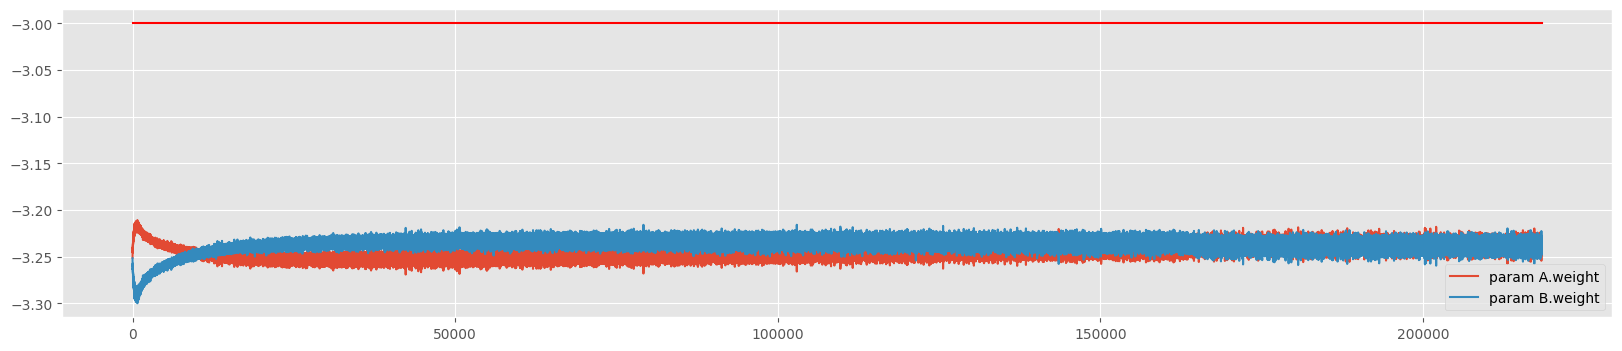

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))
legends = []
for i, (name, p) in enumerate(model.named_parameters()):
    plt.plot([ratios[j][i] for j in range(len(ratios))])
    legends.append('param {}'.format(name))
plt.plot([0, len(ratios)], [-3, -3], 'r')
plt.legend(legends)